# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [3]:
dataset = pd.read_csv('games_reviews_genres_encoded.csv')
dataset['Indie'] = dataset['Indie'].astype(int)
dataset['Utilities'] = dataset['Utilities'].astype(int)
dataset['Sports'] = dataset['Sports'].astype(int)
dataset['Massively_Multiplayer'] = dataset['Massively_Multiplayer'].astype(int)
dataset['Sexual_Content'] = dataset['Sexual_Content'].astype(int)
dataset['Casual'] = dataset['Casual'].astype(int)
dataset['Simulation'] = dataset['Simulation'].astype(int)
dataset['Adventure'] = dataset['Adventure'].astype(int)
dataset['reviews'] = dataset['reviews'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
train_dataset = train_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
test_dataset = test_dataset[['reviews', 'Indie', 'Casual', 'Adventure']]
train_dataset.head()

(6201, 31)
Index(['Unnamed: 0', 'AppID', 'reviews', 'Genres', 'Tags', 'Price',
       'Estimated.owners', 'Indie', 'Strategy', 'Action', 'Casual',
       'Simulation', 'Sports', 'Adventure', 'Early_Access', 'Utilities', 'RPG',
       'Massively_Multiplayer', 'Free_To_Play', 'Racing', 'Violent', 'Gore',
       'Animation_and_Modeling', 'Design_and_Illustration', 'Video_Production',
       'Nudity', 'Sexual_Content', 'Software_Training', 'Education',
       'Game_Development', 'Audio_Production'],
      dtype='object')


,reviews,Indie,Casual,Adventure
2036,This game is broken.\r\n\r\nIt isn't possible ...,1,0,1
572,HORRIBLE GAME definetly not worth buying there...,1,0,0
2570,Surprisingly I enjoy it despite the mixed gene...,0,0,1
5776,I thought i'd give it a go because its hard to...,1,0,0
4737,I will admit that I enjoyed The Fox’s Trail a ...,0,0,1


In [4]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
#tf_train_dataset = tf.convert_to_tensor(train_dataset)
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
tf_train_dataset.element_spec

{'reviews': TensorSpec(shape=(), dtype=tf.string, name=None),
 'Indie': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Casual': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Adventure': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [5]:
for elem in tf_train_dataset.take(1):
  print('Reviews: ', elem['reviews'].numpy())
  print('Indie: ', elem['Indie'].numpy())
  print('Casual: ', elem['Casual'].numpy())
  print('Adventure: ', elem['Adventure'].numpy())

Reviews:  b'This game is broken.\r\n\r\nIt isn\'t possible to open chests or use your "special ability," and the level doesn\'t have an exit or an end boss.'
Indie:  1
Casual:  0
Adventure:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for element in tf_train_dataset.take(1):
  print('reviews: ', element['reviews'].numpy()[:3])
  print()
  print('Indie: ', element['Indie'].numpy()[:3])
  print('Casual:', element['Casual'].numpy()[:3])
  print('Adventure: ', element['Adventure'].numpy()[:3])

reviews:  [b'Simple puzzle game. OK art style.|;|Meh.|;|Simple puzzle game. OK art style.'
 b'6'
 b"This game was absolutely terrific. I can't recommend it enough. I really want more people to dig into it, give this company the opportunity to make more.\r\n\r\nBut the big honking caveat: this is a niche game. If you're interested in hardcore, D&D turn-based RPGs with loads of complex mechanics and where failure is a real possibility, this is among the best games ever made. It really scratches that itch. More than that: I've put over 500 hours into this game, and finished it this morning for the first time. I don't spend that kind of time on a game. I just really like it - I started over 4 times, just because, before finally finishing. Now I'm trying an evil party on Ironman. I expect to survive about 10 minutes.\r\n\r\nIf you like heavy combat strategy, this is for you. If you like agonizing over character builds, look no further. If you like desperately throwing the dregs of what you 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train_dataset.map(lambda x: x['reviews']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'of', 'i', 'is',
       'it', 'you', 'this', 'in', 'that', 'for', 'but', 'with', 'are',
       'on'], dtype='<U31')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(element['reviews'])[:3].numpy()
encoded_example

array([[199, 212,   6, ...,   0,   0,   0],
       [567,   0,   0, ...,   0,   0,   0],
       [ 12,   6,  29, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", element['reviews'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Simple puzzle game. OK art style.|;|Meh.|;|Simple puzzle game. OK art style.'
Round-trip:  simple puzzle game ok art [UNK] puzzle game ok art style                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #changed from 64
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid') #scale to number of outputs
])

# Summary of the model
model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[ 0.00284313 -0.00969336 -0.00929864]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[ 0.00284313 -0.00969336 -0.00929864]


## Train the model

In [21]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))

history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 90s 903ms/step - accuracy: 0.8083 - loss: 1.6461 - val_accuracy: 0.8349 - val_loss: 1.6086
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8468 - loss: 1.6158 - val_accuracy: 0.8349 - val_loss: 1.5994
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 92s 946ms/step - accuracy: 0.8494 - loss: 1.6084 - val_accuracy: 0.8349 - val_loss: 1.6269
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 81s 843ms/step - accuracy: 0.8422 - loss: 1.6101 - val_accuracy: 0.8349 - val_loss: 1.6506
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 849ms/step - accuracy: 0.8465 - loss: 1.6209 - val_accuracy: 0.8349 - val_loss: 1.6098
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 865ms/step - accuracy: 0.8496 - loss: 1.6378 - val_accuracy: 0.8349 - val_loss: 1.6008
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 848ms/step - accuracy: 0.8423 - loss: 1.6233 - val_accuracy: 0.8349 - val_loss: 1.6125
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 850ms/step - accuracy: 0.8459 - loss: 1.6313 - val_accura

In [22]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)
# true_positives = tf.keras.metrics.TruePositives()
# true_negatives = 0
# false_positives = 0
# false_negatives = 0

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 334ms/step - accuracy: 0.8436 - loss: 1.7050
Test Loss: 1.7118160724639893
Test Accuracy: 0.8479277491569519


In [24]:
#Get the misclassified indices
incorrect = np.nonzero(model.predict_classes(encoded_test_dataset).reshape(-1,))
print(incorrect)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

(0.0, 0.6693141058087348)

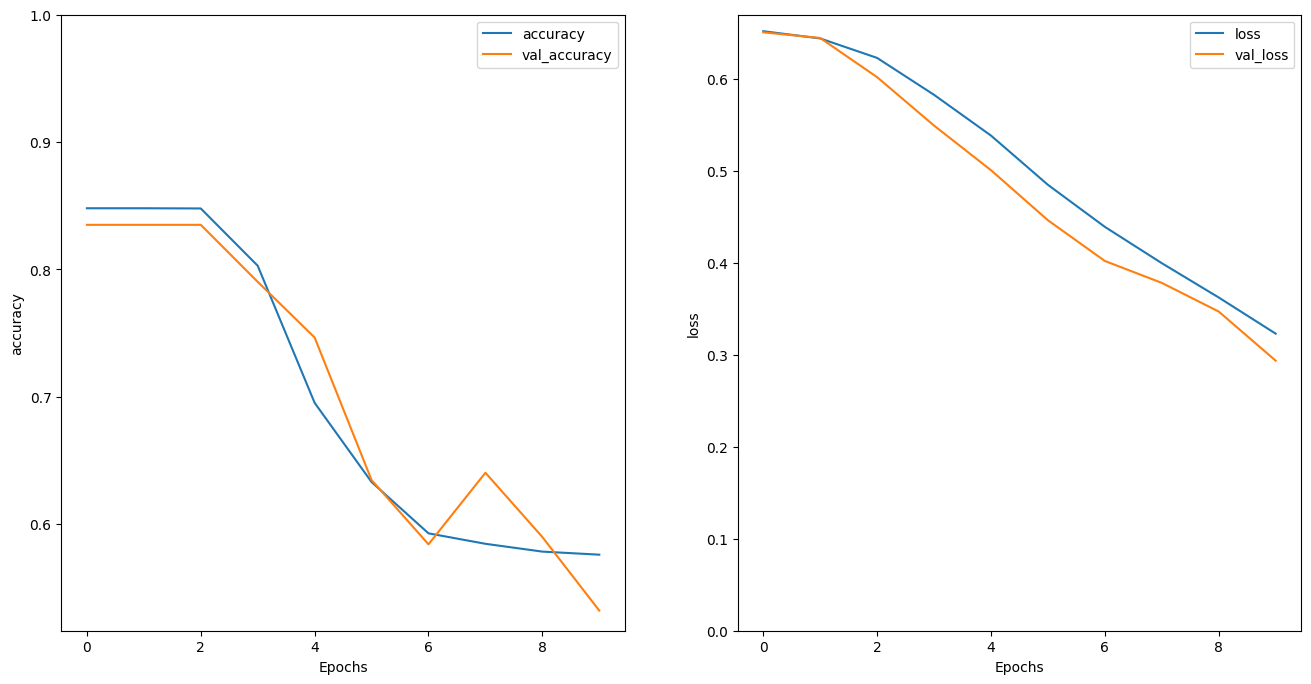

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('This indie game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was cool. The animation and the graphics '
               'were out of this world. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was not cool. The animation and the graphics '
               'were basic, cheap. I would not recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
[[0.8182237 0.8900783 0.7179658]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
[[0.80802184 0.8545601  0.80518436]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.87624866 0.90379727 0.37501472]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, use_cudnn=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

NameError: name 'tf' is not defined

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30)

Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.5764 - loss: 0.5984 - val_accuracy: 0.8188 - val_loss: 0.4095
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8313 - loss: 0.3805 - val_accuracy: 0.8630 - val_loss: 0.2952
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.8739 - loss: 0.3038 - val_accuracy: 0.9104 - val_loss: 0.2654
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.8984 - loss: 0.2607 - val_accuracy: 0.9234 - val_loss: 0.2080
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9133 - loss: 0.2291 - val_accuracy: 0.9089 - val_loss: 0.2612
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9064 - loss: 0.2487 - val_accuracy: 0.9245 - val_loss: 0.1864
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.9272 - loss: 0.1961 - val_accuracy: 0.9427 - val_loss: 0.1662
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9351 - loss: 0.1858 -

In [ ]:
test_loss, test_acc = model.evaluate(encoded_test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

460/460 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9471 - loss: 0.1625
Test Loss: 0.16997113823890686
Test Accuracy: 0.9440195560455322


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[[-2.170004]]


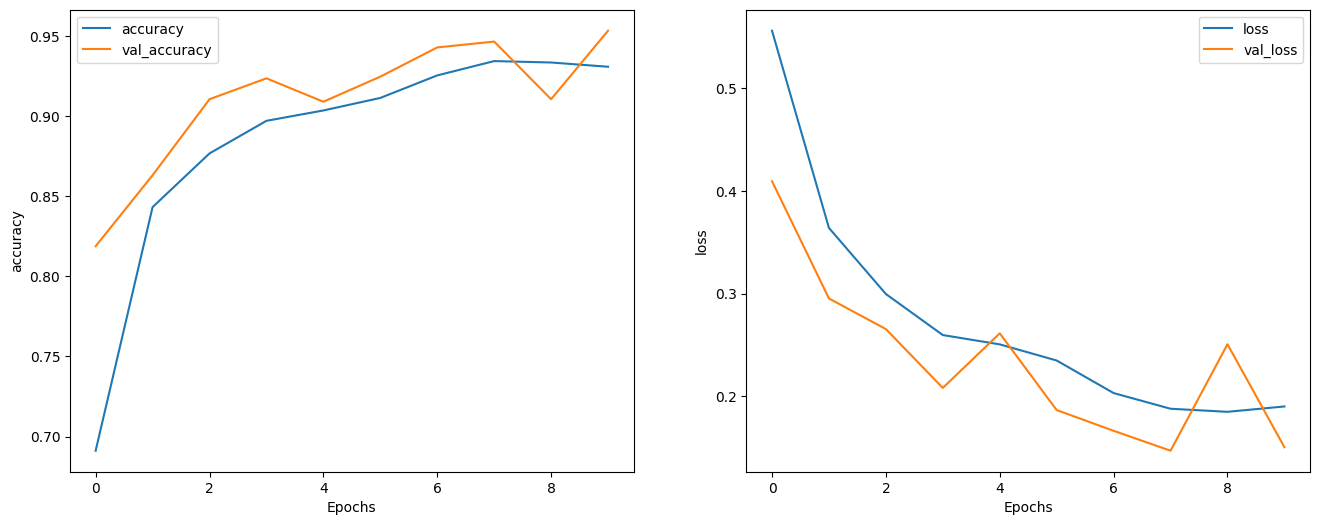

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
